# Multi-Class Classification Model for [Project Name] Using Python version 10
### David Lowe
### June 17, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: [Sample Paragraph - The purpose of this project is to construct prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Glass Identification dataset is a multi-class classification situation where we are trying to predict one of the six possible outcomes.]

INTRODUCTION: [Sample Paragraph - The dataset involves predicting, from USA Forensic Science Service, six types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc). The study of classification of types of glass was also partly motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence…if it is correctly identified!]

ANALYSIS: [Sample Paragraph - The baseline performance of the machine learning algorithms achieved an average accuracy of 67.60%. Two algorithms (Bagged Decision Trees and Random Forest) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Bagged Decision Trees turned in the top overall result and achieved an accuracy metric of 75.16%. By using the optimized parameters, the Bagged Decision Trees algorithm processed the testing dataset with an accuracy of 69.23%, which was significantly below the training data and possibly a result of over-fitting.

CONCLUSION: [Sample Paragraph - For this iteration, the Bagged Decision Trees algorithm achieved the best overall results using the training and testing datasets. For this dataset, Bagged Decision Trees should be considered for further modeling.]

Dataset Used: Glass Identification Data Set

Dataset ML Model: Multi-Class classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/glass+identification]

One source of potential performance benchmarks: [https://www.kaggle.com/uciml/glass]

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
# Set up the muteEmail flag to stop sending progress emails (setting to False will send emails!)
muteEmail = False

In [4]:
if (not muteEmail): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [5]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
colNames = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','targetVar']
xy_original_df = read_csv(inputFile, names=colNames, sep=',', header=None, index_col=0)

In [6]:
# Take a peek at the dataframe after the import
xy_original_df.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [7]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI           214 non-null float64
Na           214 non-null float64
Mg           214 non-null float64
Al           214 non-null float64
Si           214 non-null float64
K            214 non-null float64
Ca           214 non-null float64
Ba           214 non-null float64
Fe           214 non-null float64
targetVar    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [8]:
print(xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_original_df.isnull().sum().sum())

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [9]:
# Not applicable for this iteration of the project
# Sample code for performing basic data cleaning tasks

# Dropping features
# xy_original_df.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# xy_original_df['col_name'].fillna('someValue', inplace=True)
# xy_original_df['col_name'].fillna(value=xy_original_df['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# xy_original_df.column_name = xy_original_df.column_name.astype('int')
# xy_original_df.column_name = xy_original_df.column_name.astype('category')

# Convert features with 1/0 levels into categorical feature of Y/N
# def reClassSomecol(code):
#     if (code == 1): return 'Y'
#     else: return 'N'
# xy_original_df['targetVar] = xy_original_df['targetVar'].apply(reClassSomecol)

In [10]:
# Take a peek at the dataframe after the cleaning
xy_original_df.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [11]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI           214 non-null float64
Na           214 non-null float64
Mg           214 non-null float64
Al           214 non-null float64
Si           214 non-null float64
K            214 non-null float64
Ca           214 non-null float64
Ba           214 non-null float64
Fe           214 non-null float64
targetVar    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [12]:
print(xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_original_df.isnull().sum().sum())

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Training and Testing Sets

In [13]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [14]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
# xy_original_df = xy_original_df.rename(columns={'Type': 'targetVar'})

In [15]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (214, 10) xy_train_df.shape: (149, 10)
x_train_df.shape: (149, 9) y_train_df.shape: (149,)
x_test_df.shape: (65, 9) y_test_df.shape: (65,)


### 1.f) Set up the key parameters to be used in the script

In [16]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = None

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
if (not muteEmail): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [18]:
if (not muteEmail): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [19]:
xy_original_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


#### 2.a.ii) Dimensions of the dataset.

In [20]:
xy_original_df.shape

(214, 10)

#### 2.a.iii) Types of the attributes.

In [21]:
x_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 9 columns):
RI    214 non-null float64
Na    214 non-null float64
Mg    214 non-null float64
Al    214 non-null float64
Si    214 non-null float64
K     214 non-null float64
Ca    214 non-null float64
Ba    214 non-null float64
Fe    214 non-null float64
dtypes: float64(9)
memory usage: 16.7 KB


In [22]:
x_original_df.dtypes

RI    float64
Na    float64
Mg    float64
Al    float64
Si    float64
K     float64
Ca    float64
Ba    float64
Fe    float64
dtype: object

#### 2.a.iv) Statistical summary of all attributes.

In [23]:
x_original_df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


#### 2.a.v) Summarize the levels of the class attribute.

In [24]:
xy_original_df.groupby('targetVar').size()

targetVar
1    70
2    76
3    17
5    13
6     9
7    29
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

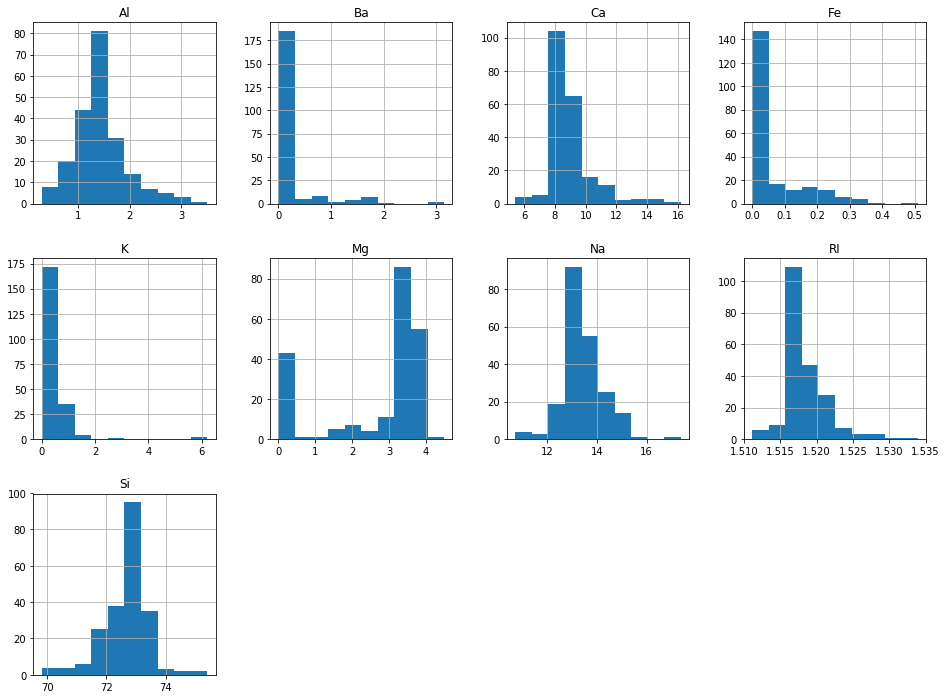

In [25]:
# Histograms for each attribute
x_original_df.hist(layout=(dispRow,dispCol))
pyplot.show()

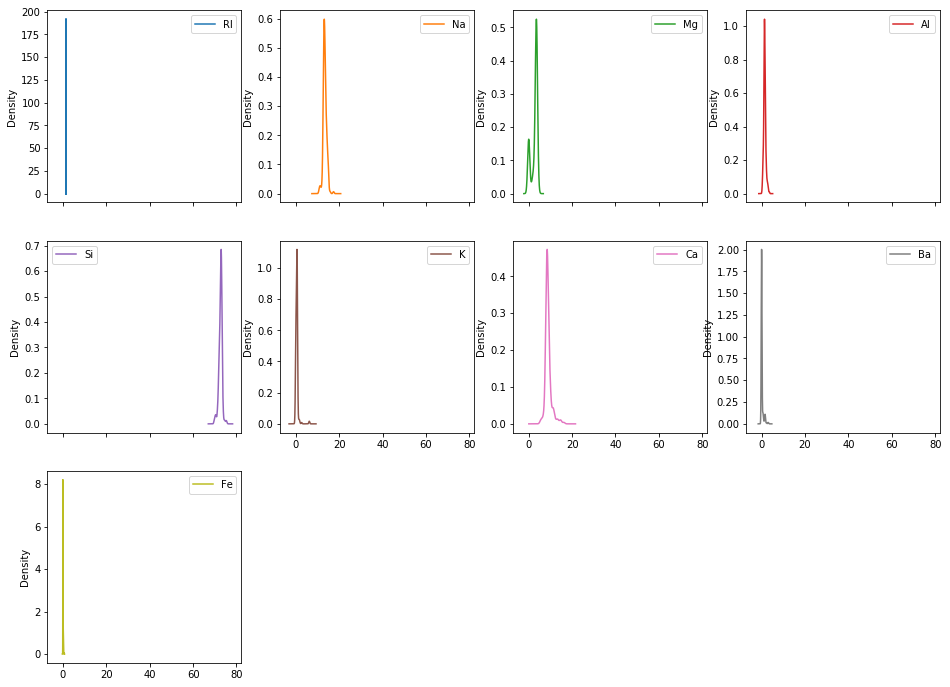

In [26]:
# Density plot for each attribute
x_original_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

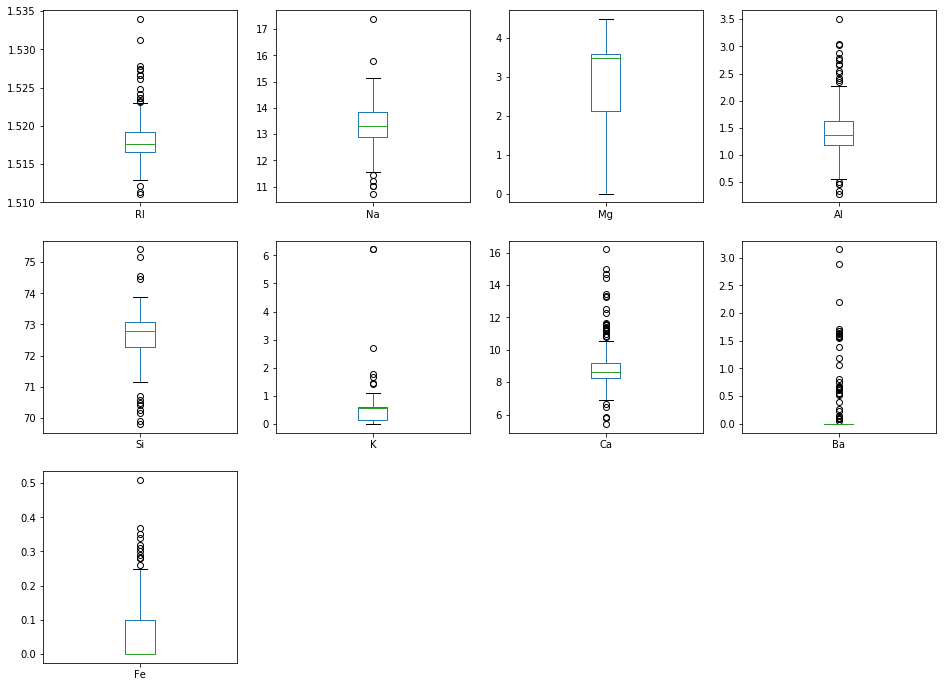

In [27]:
# Box and Whisker plot for each attribute
x_original_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [28]:
# Scatterplot matrix
# scatter_matrix(x_original_df)
# pyplot.show()

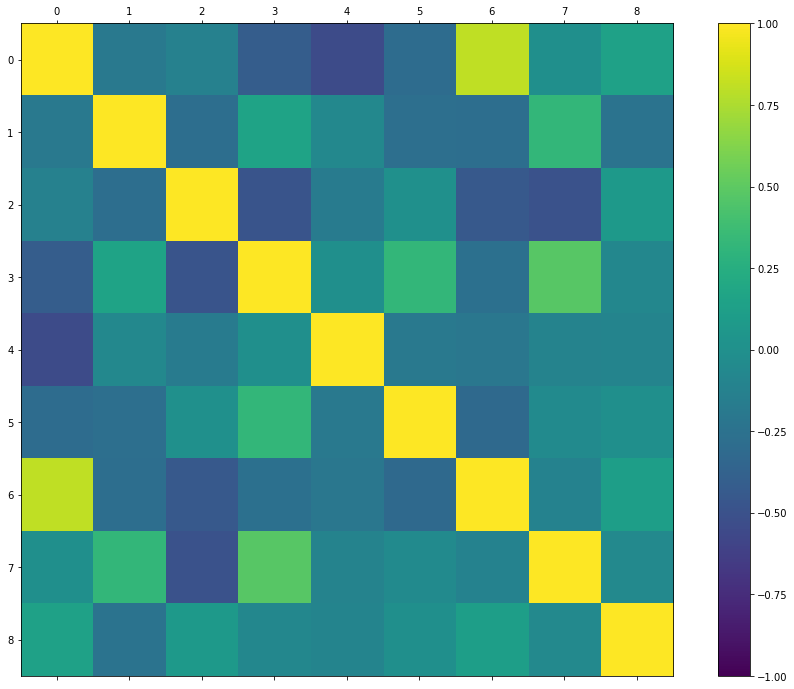

In [29]:
# Correlation matrix
fig = pyplot.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = x_original_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [30]:
if (not muteEmail): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [31]:
if (not muteEmail): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.b) Feature Selection

In [32]:
# Not applicable for this iteration of the project
# Sample Code for finding collinear features (Block #1 of 3)
# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [33]:
# Sample Code for finding collinear features (Block #2 of 3)
# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = x_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [34]:
# Sample Code for finding collinear features (Block #3 of 3)
# Drop the highly collinear features
# x_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# x_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [35]:
# Not applicable for this iteration of the project
# Sample code for performing Attribute Importance Ranking (Block #1 of 3)
# Feature Importance with Gradient Boosting Classifier
# x_impVal = x_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=seedNum)
# model.fit(x_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = x_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [36]:
# Sample code for performing Attribute Importance Ranking (Block #2 of 3)
# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [37]:
# Sample code for performing Attribute Importance Ranking (Block #3 of 3)
# Removing the unselected attributes from the training and validation dataframes
# x_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# x_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [38]:
# Not applicable for this iteration of the project
# Sample code for performing Recursive Feature Elimination (Block #1 of 3)
# Using the Linear Discriminant Analysis algorithm, we perform the Recursive Feature Elimination (RFE) technique
# x_rfeVal = x_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estimator = LinearDiscriminantAnalysis(random_state=seedNum)
# selector = RFE(estimator, 40)
# selector = selector.fit(x_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The mask of selected features:\n',selector.ranking_)

In [39]:
# Sample code for performing Recursive Feature Elimination (Block #2 of 3)
# Remove the unselected attributes from the training dataframes
# x_train_df = x_train_df[x_train_df.columns[selector.support_]]
# print(x_train_df.shape)
# x_train_df.head()

In [40]:
# Sample code for performing Recursive Feature Elimination (Block #3 of 3)
# Remove the unselected attributes from the validation dataframes
# x_test_df = x_test_df[x_test_df.columns[selector.support_]]
# print(x_test_df.shape)
# x_test_df.head()

### 3.c) Data Transforms

In [41]:
# Not applicable for this iteration of the project
# Sample code for performing SMOTE transformation on the training data (Block #1 of 2)
# x_train_imbal = x_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("x_train_imbal.shape: {} y_train_imbal.shape: {}".format(x_train_imbal.shape, y_train_imbal.shape))

In [42]:
# Sample code for performing SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=seedNum, sampling_strategy=1.0)
# x_train, y_train = sm.fit_sample(x_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

In [43]:
# Not applicable for this iteration of the project
# Sample code for performing one-hot-encoding

# Apply the One-Hot-Encoding (dummy variable handling) technique
# x_original_df = get_dummies(x_original_df)
# print(x_original_df.dtypes)

### 3.d) Display the Final Datasets for Model-Building

In [44]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_train.shape: (149, 9) y_train.shape: (149,)
x_test.shape: (65, 9) y_test.shape: (65,)


In [45]:
if (not muteEmail): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and five ensemble algorithms:

Linear Algorithm: Linear Discriminant Analysis

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged Decision Trees, Random Forest, Extra Trees, Stochastic Gradient Boosting, and eXtreme Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [46]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [47]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier(n_jobs=cpu_num)))
models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [48]:
# Generate model in turn
for name, model in models:
	if (not muteEmail): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	if (not muteEmail): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LDA: 0.635238 (0.199366)
Model training time: 0:00:00.017112
CART: 0.675714 (0.159683)
Model training time: 0:00:00.013113
KNN: 0.601905 (0.147898)
Model training time: 0:00:00.022150
BT: 0.723333 (0.103333)
Model training time: 0:00:00.116450
RF: 0.702381 (0.144047)
Model training time: 0:00:00.103355
ET: 0.696667 (0.113969)
Model training time: 0:00:00.092760
GBM: 0.682857 (0.115788)
Model training time: 0:00:03.673885
Average metrics (accuracy) from all models: 0.674013605442177


### 4.b) Spot-checking baseline algorithms

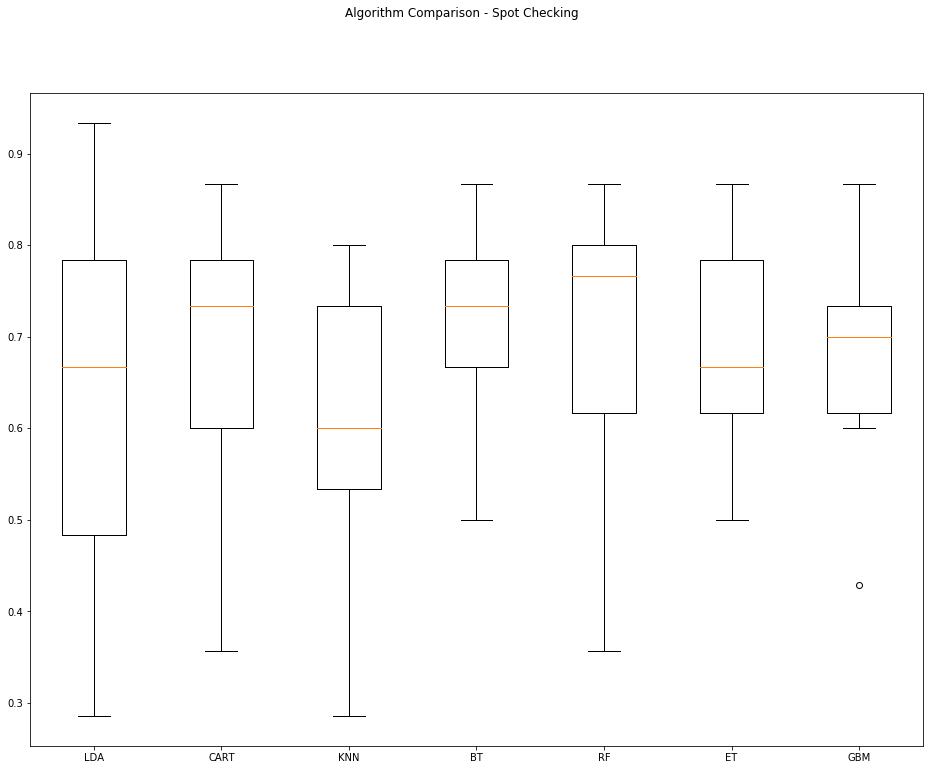

In [49]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [50]:
# Set up the comparison array
results = []
names = []

In [51]:
# Tuning algorithm #1 - Bagged Decision Trees
if (not muteEmail): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([10,20,30,40,50]))
model1 = BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('BDT')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (not muteEmail): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.751678 using {'n_estimators': 20}
0.724832 (0.102041) with: {'n_estimators': 10}
0.751678 (0.113282) with: {'n_estimators': 20}
0.738255 (0.127707) with: {'n_estimators': 30}
0.731544 (0.159294) with: {'n_estimators': 40}
0.738255 (0.137817) with: {'n_estimators': 50}
Model training time: 0:00:01.902882


In [52]:
# Tuning algorithm #2 - Random Forest
if (not muteEmail): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([50,75,100,125,150]))
model2 = RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('RF')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (not muteEmail): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.744966 using {'n_estimators': 100}
0.738255 (0.141026) with: {'n_estimators': 50}
0.738255 (0.137817) with: {'n_estimators': 75}
0.744966 (0.148373) with: {'n_estimators': 100}
0.738255 (0.141026) with: {'n_estimators': 125}
0.718121 (0.135421) with: {'n_estimators': 150}
Model training time: 0:00:05.148418


### 5.b) Compare Algorithms After Tuning

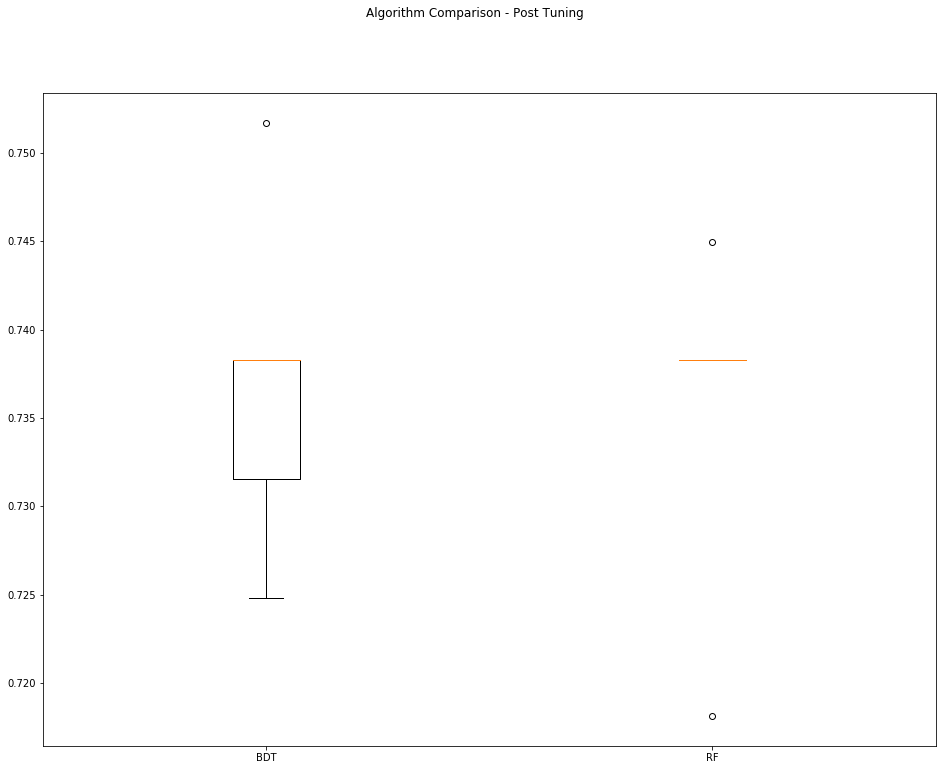

In [53]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [54]:
if (not muteEmail): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [55]:
model = BaggingClassifier(n_estimators=20, random_state=seedNum, n_jobs=cpu_num)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6923076923076923
[[15  5  4  0  0  1]
 [ 2 19  0  0  0  1]
 [ 2  1  2  0  0  0]
 [ 0  0  0  2  0  1]
 [ 1  1  0  0  1  0]
 [ 1  0  0  0  0  6]]
              precision    recall  f1-score   support

           1       0.71      0.60      0.65        25
           2       0.73      0.86      0.79        22
           3       0.33      0.40      0.36         5
           5       1.00      0.67      0.80         3
           6       1.00      0.33      0.50         3
           7       0.67      0.86      0.75         7

   micro avg       0.69      0.69      0.69        65
   macro avg       0.74      0.62      0.64        65
weighted avg       0.71      0.69      0.69        65



### 6.b) Create standalone model on entire training dataset

In [56]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = BaggingClassifier(n_estimators=20, random_state=seedNum, n_jobs=cpu_num)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (214, 9) y_complete.shape: (214,)
Model training time: 0:00:00.040760


### 6.c) Save model for later use

In [57]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [58]:
if (not muteEmail): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [59]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:52.183073
